In [1]:
# Instalación de bibliotecas
!pip install tensorflow pandas matplotlib opencv-python scikit-learn
import os
import zipfile
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013
!kaggle datasets download -d tapakah68/facial-emotion-recognitio
!kaggle datasets download -d ananthu017/emotion-detection-fer
!kaggle datasets download -d samaneheslamifar/facial-emotion-expression
!kaggle datasets download -d missaouimohamedamine/face-emotion-dataset
!kaggle datasets download -d tonny22/dataset-of-faces-as-per-emotions

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 111MB/s] 
100% 60.3M/60.3M [00:00<00:00, 109MB/s]
403 - Forbidden - Permission 'datasets.get' was denied
Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 97% 63.0M/65.2M [00:01<00:00, 45.7MB/s]
100% 65.2M/65.2M [00:01<00:00, 45.1MB/s]
403 - Forbidden - Permission 'datasets.get' was denied
Dataset URL: https://www.kaggle.com/datasets/missaouimohamedamine/face-emotion-dataset
License(s): apache-2.0
 92% 113M/123M [00:01<00:00, 97.3MB/s] 
100% 123M/123M [00:01<00:00, 74.3MB/s]
Dataset URL: https://www.kaggle.com/datasets/tonny22/dataset-of-faces-as-per-emotions
License(s): unknown
 99% 457M/464M [00:08<00:00, 60.8MB/s]
100% 464M/464M [00:08<00:00, 58.5MB/s]


In [3]:
# Directorio donde están los archivos .zip descargados
download_dir = '/content/'

# Listamos todos los archivos en el directorio
zip_files = [f for f in os.listdir(download_dir) if f.endswith('.zip')]

# Descomprimir todos los archivos .zip
for zip_file in zip_files:
    zip_path = os.path.join(download_dir, zip_file)
    extract_dir = os.path.join(download_dir, zip_file.replace('.zip', ''))
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Descomprimido: {zip_file} en {extract_dir}")


Descomprimido: emotion-detection-fer.zip en /content/emotion-detection-fer
Descomprimido: fer2013.zip en /content/fer2013
Descomprimido: dataset-of-faces-as-per-emotions.zip en /content/dataset-of-faces-as-per-emotions
Descomprimido: face-emotion-dataset.zip en /content/face-emotion-dataset


In [4]:
# Mapeo de las etiquetas a las nuevas categorías numeradas
label_mapping = {
    'angry': 0,        # angry -> 0
    'neutral': 1,      # neutral -> 1
    'disgust': 2,      # disgust -> 2
    'fear': 3,         # fear -> 3
    'happy': 4,        # happy -> 4
    'sad': 5,          # sad -> 5
    'surprise': 6,     # surprise -> 6
}

In [5]:
#Función para cargar imágenes y etiquetarlas
def load_images_and_labels(dataset_path, label_mapping):
    image_paths = []
    labels = []

    # Recorrer las carpetas dentro del dataset
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)


        if os.path.isdir(class_path):

            normalized_class_folder = class_folder.lower()


            if normalized_class_folder in ['angry', 'anger']:
                mapped_label = label_mapping['angry']
            elif normalized_class_folder in ['sad', 'sadness']:
                mapped_label = label_mapping['sad']
            elif normalized_class_folder in ['happy', 'happiness']:
                mapped_label = label_mapping['happy']
            elif normalized_class_folder in ['fear', 'fearful']:
                mapped_label = label_mapping['fear']
            elif normalized_class_folder in ['surprise', 'surprised']:
                mapped_label = label_mapping['surprise']
            elif normalized_class_folder in ['disgust', 'disgusted']:
                mapped_label = label_mapping['disgust']
            elif normalized_class_folder in ['neutrality', 'noemo']:
                mapped_label = label_mapping['neutral']
            elif normalized_class_folder in label_mapping:
                mapped_label = label_mapping[normalized_class_folder]
            else:
                print(f"Etiqueta no mapeada: {class_folder}")
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(mapped_label)

    # Crear un DataFrame con las rutas de imágenes y las etiquetas mapeadas
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df


In [6]:
#Lo aplicamos para los otros datasets que son compatibles con la funcion

dataset_path_1 = '/content/fer2013/test'#
dataset_path_2 = '/content/fer2013/train'#
dataset_path_3 = '/content/emotion-detection-fer/test'#
dataset_path_4 = '/content/emotion-detection-fer/train'#
dataset_path_5 = '/content/face-emotion-dataset/test'#
dataset_path_6 = '/content/face-emotion-dataset/train'#
dataset_path_7 = '/content/dataset-of-faces-as-per-emotions/Dataset_emotions'#

df_test_1 = load_images_and_labels(dataset_path_1, label_mapping)
df_test_2 = load_images_and_labels(dataset_path_2, label_mapping)
df_test_3 = load_images_and_labels(dataset_path_3, label_mapping)
df_test_4 = load_images_and_labels(dataset_path_4, label_mapping)
df_test_5 = load_images_and_labels(dataset_path_5, label_mapping)
df_test_6 = load_images_and_labels(dataset_path_6, label_mapping)
df_test_7 = load_images_and_labels(dataset_path_7, label_mapping)

# Verificar la distribución de las etiquetas
print(df_test_1['label'].value_counts())
print(df_test_2['label'].value_counts())
print(df_test_3['label'].value_counts())
print(df_test_4['label'].value_counts())
print(df_test_5['label'].value_counts())
print(df_test_6['label'].value_counts())
print(df_test_7['label'].value_counts())

label
4    1774
5    1247
1    1233
3    1024
0     958
6     831
2     111
Name: count, dtype: int64
label
4    7215
1    4965
5    4830
3    4097
0    3995
6    3171
2     436
Name: count, dtype: int64
label
4    1774
5    1247
1    1233
3    1024
0     958
6     831
2     111
Name: count, dtype: int64
label
4    7215
1    4965
5    4830
3    4097
0    3995
6    3171
2     436
Name: count, dtype: int64
label
4    3599
1    2449
5    2386
3    2042
0    1918
6    1628
2     810
Name: count, dtype: int64
label
4    14379
1     9947
5     9768
3     8200
0     7988
6     6376
2     3054
Name: count, dtype: int64
label
4    614
5    525
0    441
Name: count, dtype: int64


In [7]:
#Ahora unimos los dataframes en uno solo
df_combined = pd.concat([ df_test_1, df_test_2, df_test_3, df_test_4, df_test_5, df_test_6, df_test_7], ignore_index=True)

# Ver las primeras filas del DataFrame combinado
print(df_combined.head())


# Verificar la distribución de las etiquetas
print(df_combined['label'].value_counts())

                                          image_path  label
0  /content/fer2013/test/neutral/PublicTest_34157...      1
1  /content/fer2013/test/neutral/PublicTest_56071...      1
2  /content/fer2013/test/neutral/PrivateTest_5386...      1
3  /content/fer2013/test/neutral/PublicTest_85967...      1
4  /content/fer2013/test/neutral/PublicTest_45584...      1
label
4    36570
5    24833
1    24792
3    20484
0    20253
6    16008
2     4958
Name: count, dtype: int64


In [8]:
# Filtra las imágenes de la clase 2
df_class_2 = df_combined[df_combined['label'] == 2]

# Configura las transformaciones
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directorio de salida para las imágenes aumentadas
output_dir = "augmented_class_2"
os.makedirs(output_dir, exist_ok=True)

# Tamaño de las imágenes (ajustar si es diferente)
img_size = (48, 48)

# Número de imágenes aumentadas por ejemplo original
n_augmentations = 10

for index, row in df_class_2.iterrows():
    img_path = row['image_path']

    # Cargar la imagen original
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error al cargar la imagen: {img_path}")
        continue

    # Redimensionar si es necesario
    img = cv2.resize(img, img_size)

    # Expandir dimensión para adaptarse a ImageDataGenerator
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  # (1, img_size[0], img_size[1], 1)

    # Generar imágenes aumentadas
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=output_dir,
                              save_prefix='class_2', save_format='png'):
        i += 1
        if i >= n_augmentations:
            break  # Limitar el número de augmentaciones por imagen

print(f"Datos aumentados guardados en: {output_dir}")


# Obtener los nuevos paths de las imágenes aumentadas
augmented_images = glob.glob(os.path.join(output_dir, "*.png"))

# Crear un nuevo dataframe para las imágenes aumentadas
df_augmented = pd.DataFrame({
    'image_path': augmented_images,
    'label': 2  # Etiqueta correspondiente
})

# Concatenar con el dataset original
df_new = pd.concat([df_combined, df_augmented], ignore_index=True)

# Ver las primeras filas del nuevo DataFrame
print(df_new.head())


# Verificar la distribución de las etiquetas
print(df_new['label'].value_counts())


Datos aumentados guardados en: augmented_class_2
                                          image_path  label
0  /content/fer2013/test/neutral/PublicTest_34157...      1
1  /content/fer2013/test/neutral/PublicTest_56071...      1
2  /content/fer2013/test/neutral/PrivateTest_5386...      1
3  /content/fer2013/test/neutral/PublicTest_85967...      1
4  /content/fer2013/test/neutral/PublicTest_45584...      1
label
4    36570
5    24833
1    24792
3    20484
0    20253
6    16008
2    14895
Name: count, dtype: int64


In [9]:
num_eliminar_4 = 21000
num_eliminar_5 = 9000
num_eliminar_1 = 9000
num_eliminar_0 = 5000
num_eliminar_3 = 5000

df_class_4 = df_new[df_new['label'] == 4]
df_class_5 = df_new[df_new['label'] == 5]
df_class_1 = df_new[df_new['label'] == 1]
df_class_0 = df_new[df_new['label'] == 0]
df_class_3 = df_new[df_new['label'] == 3]

# Asegúrate de que num_eliminar sea menor o igual al tamaño de df_class_4
num_eliminar_4 = min(num_eliminar_4, len(df_class_4))
num_eliminar_5 = min(num_eliminar_5, len(df_class_5))
num_eliminar_1 = min(num_eliminar_1, len(df_class_1))
num_eliminar_0 = min(num_eliminar_0, len(df_class_0))
num_eliminar_3 = min(num_eliminar_3, len(df_class_3))

# Selecciona índices aleatorios para eliminar
# Usamos .index para obtener los índices del DataFrame
indices_eliminar = random.sample(list(df_class_4.index), num_eliminar_4) + random.sample(list(df_class_5.index), num_eliminar_5) + random.sample(list(df_class_1.index), num_eliminar_1) + random.sample(list(df_class_0.index), num_eliminar_0)+ random.sample(list(df_class_3.index), num_eliminar_3)

# Elimina los índices seleccionados de df_combined (no de df, que no está definido)
df_filtrado = df_new.drop(indices_eliminar)


# Verificar la distribución de las etiquetas
print(df_filtrado['label'].value_counts())

label
6    16008
5    15833
1    15792
4    15570
3    15484
0    15253
2    14895
Name: count, dtype: int64


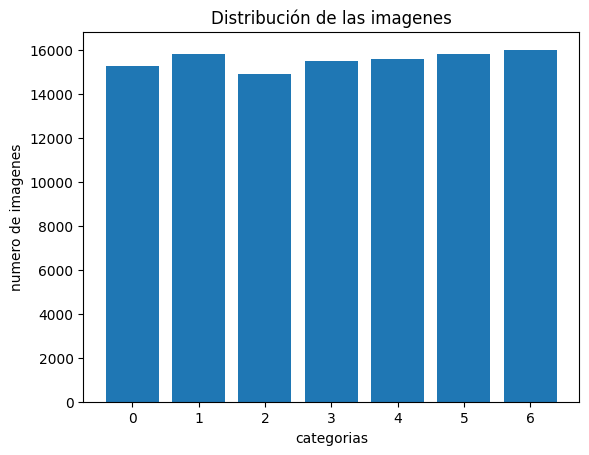

In [10]:
x = df_filtrado['label'].value_counts()
plt.bar(x.index, x.values)
plt.xlabel('categorias')
plt.ylabel('numero de imagenes')
plt.title('Distribución de las imagenes')
plt.show()

In [11]:
# Verificar si las rutas de las imágenes son correctas
for index, row in df_filtrado.iterrows():
    if not os.path.exists(row['image_path']):
        print(f"¡Ruta no válida! {row['image_path']}")

In [12]:
def load_and_preprocess_images(df, img_size=(48, 48)):
    images = []
    labels = []

    for index, row in df.iterrows():

        if not os.path.exists(row['image_path']):
            print(f"Imagen no encontrada: {row['image_path']}")
            continue


        img = cv2.imread(row['image_path'])

        if img is None:
            print(f"Error al cargar la imagen: {row['image_path']}")
            continue

        # Convertir la imagen a escala de grises y redimensionar
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, img_size)

        # Normalizar la imagen
        img = img / 255.0

        images.append(img)
        labels.append(row['label'])

    # Convertir a arrays de numpy
    images = np.array(images)
    labels = np.array(labels)

    # Expande las dimensiones para la compatibilidad con CNN
    images = images.reshape(-1, img_size[0], img_size[1], 1)

    return images, labels

In [13]:
# Dividir en entrenamiento (60%), validación (20%) y prueba (20%)
images, labels = load_and_preprocess_images(df_filtrado)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Entrenamiento: {len(X_train)} muestras")
print(f"Validación: {len(X_val)} muestras")
print(f"Prueba: {len(X_test)} muestras")

Entrenamiento: 65301 muestras
Validación: 21767 muestras
Prueba: 21767 muestras


In [14]:
# Crear el modelo CNN
model = models.Sequential([

    # Primera capa convolucional
    layers.Conv2D(32, (3, 3),padding='same', input_shape=(48, 48, 1)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='swish', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

     # Cuarta capa convolucional
    layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    layers.MaxPooling2D((2, 2)),


    # Aplanar y capas densas
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    layers.Dense(250, activation='swish', kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.25),

    layers.Dense(170, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),


    # Capa de salida
    layers.Dense(7, activation='softmax')
])

# Configurar el optimizador
optimizer = Adam(learning_rate=0.0001)

# Compilar el modelo
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


# Resumen del modelo
model.summary()

# Entrenar el modelo con EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler] # Agregar el callback
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,745,765 (6.66 MB)

 Trainable params: 1,742,941 (6.65 MB)

 Non-trainable params: 2,824 (11.03 KB)

Epoch 1/100
 654/2041 ━━━━━━━━━━━━━━━━━━━━ 9:10 397ms/step - accuracy: 0.1801 - loss: 18.9587

KeyboardInterrupt: 

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

In [ ]:
# Predicciones del modelo
y_pred = model.predict(X_test)

# Convertir las probabilidades a clases (índice con la mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)


# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Matriz de confusión:")
print(conf_matrix)

In [ ]:
# Etiquetas de las clases
class_names = ['Angry', 'Neutral', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred,axis=1)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# Reporte completo de clasificación
print(classification_report(y_val, y_pred_classes, target_names=class_names))

In [ ]:
# Guardar el modelo entrenado
model.save('Clasificador_emociones.h5')
# Guardar el modelo en formato Keras
model.save('/content/Clasificador_emociones.keras')